# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter
#import timm
#from torchvision.models import wide_resnet50_2, resnet18
#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import ResNet38 as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_SubSeq/frame64_3/config.yaml'

In [7]:
torch.cuda.is_available()

True

## make path list

- __train_paths__ ([dict]): Each Machine Type
    - __ToyCar__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) :paths
    - __ToyTrain__ ([dict]): Each dataset
        - train ([list]) : paths
        - valid_source ([list]) : paths
        - valid_target ([list]) : paths
    - ...

In [8]:
dev_paths = {}

for machine_type in machine_types:
    # dev train
    dev_train_paths = [f"{dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/train")]
    dev_train_paths = sorted(dev_train_paths)
    
    # add_dev train
    add_dev_paths = [f"{add_dev_dir}/{machine_type}/train/" + file for file in os.listdir(f"{add_dev_dir}/{machine_type}/train")]
    add_dev_paths = sorted(add_dev_paths)
    
    # dev_source valid
    dev_source_paths = [f"{dev_dir}/{machine_type}/source_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/source_test")]
    dev_source_paths = sorted(dev_source_paths)
    
    # dev_target valid
    dev_target_paths = [f"{dev_dir}/{machine_type}/target_test/" + file for file in os.listdir(f"{dev_dir}/{machine_type}/target_test")]
    dev_target_paths = sorted(dev_target_paths)
    
    # bundle
    dev_paths[machine_type] = {}
    dev_paths[machine_type]['train'] = dev_train_paths + add_dev_paths
    dev_paths[machine_type]['valid_source'] = dev_source_paths
    dev_paths[machine_type]['valid_target'] = dev_target_paths

In [9]:
dev_paths['fan']['train'][-1]

'/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/add_dev_data/fan/train/section_05_target_train_normal_0002_strength_1_temp_max.wav'

## training

In [10]:
#############################################################################
# run
#############################################################################
def run(machine_type, dev_paths):
    com.tic()
    
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(dev_paths, machine_type)
    # parameter setting
    logger.info('FEATURE EXTRACTION')
    net = Model()
    pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_ROOT'])
    net.load_state_dict(pretrained_dict['model'], strict=False)
    _ = modeler.extract_net(net,
                            dataloaders_dict,
                            OUT_FEATURE_DIR,
                            machine_type)
    #out_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    #pd.to_pickle(output_dicts, out_path)
    logger.info(f'SAVE SUCCESS : {OUT_FEATURE_DIR}')
    
    com.toc()

# run

In [11]:
#net = resnet18(pretrained=True, progress=True)

In [12]:
#net.layer4

In [13]:
for machine_type in machine_types:
    run(machine_type, dev_paths)

2021-05-25 20:48:58,683 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-05-25 20:48:58,685 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-25 20:49:01,931 - 00_train.py - INFO - FEATURE EXTRACTION
100%|██████████| 301/301 [11:08<00:00,  2.22s/it]
2021-05-25 21:00:24,455 - pytorch_modeler.py - INFO - success save features : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_SubSeq/frame64_3/extraction_features/fan_train_features.pkl
100%|██████████| 300/300 [09:41<00:00,  1.94s/it]
2021-05-25 21:10:17,721 - pytorch_modeler.py - INFO - success save features : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_SubSeq/frame64_3/extraction_features/fan_valid_source_features.pkl
100%|██████████| 300/300 [08:38<00:00,  1.73s/it]
2021-05-25 21:19:08,235 - pytorch_modeler.py - INFO - success save features : /media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_SubSeq/frame64_3/extraction_features/fan_valid_target_features.pkl
2021-05-25 21:19:08

In [14]:
#run(machine_types[0], dev_paths)

In [14]:
machine_type = 'fan'
phase = ['train', 'valid_source', 'valid_target']
input_path = f'{OUT_FEATURE_DIR}/{machine_type}_{phase[0]}_features.pkl'
ext_data = pd.read_pickle(input_path)

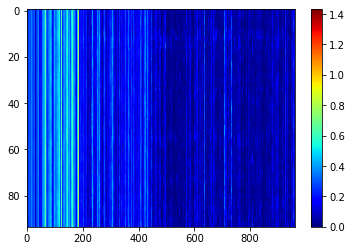

In [17]:
plt.imshow(ext_data['features'][0], aspect='auto', cmap='jet')
plt.colorbar()

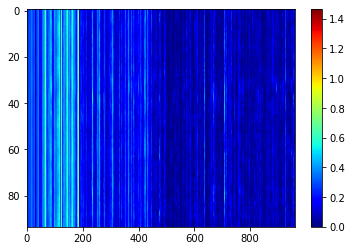

In [20]:
plt.imshow(ext_data['features'][900], aspect='auto', cmap='jet')
plt.colorbar()

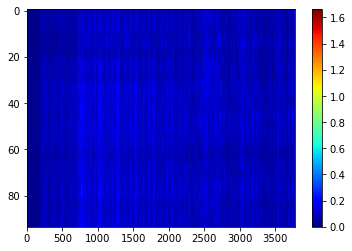

In [38]:
plt.imshow(np.abs(ext_data[4000]['features']-ext_data[1]['features']), aspect='auto', cmap='jet')
plt.colorbar()

In [ ]:
plt.imshow(ext_data['train'][0]['features'], cmap='jet', aspect='auto')

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(ext_data['train'][0]['features'][0])

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(ext_data['train'][0]['features'][20])

In [ ]:
plt.figure(figsize=(20,3))
plt.plot(ext_data['valid_source'][0]['features'][5])

In [ ]:
plt.imshow(ext_data['valid_source'][0]['features'], cmap='jet', aspect='auto')

In [ ]:
ext_data['train'][0]['features'].shape

In [ ]:
ext_data['valid_source'][0]['features'].shape

In [ ]:
plt.imshow(ext_data['train']['features'][:,:64], cmap='jet', aspect='auto')

In [ ]:
plt.imshow(ext_data['train']['features'][:,64:128], cmap='jet', aspect='auto')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['train']['features'][:1000,:], cmap='jet', aspect='auto')
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['valid_source']['features'], cmap='jet', aspect='auto')
plt.colorbar()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(ext_data['valid_target']['features'], cmap='jet', aspect='auto')
plt.colorbar()

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)